In [1]:
import seaborn as sns
import os
import sys
import numpy as np
import random

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiments.result_buckets import human_results
from experiments.bucket_analysis import BucketDatasetResult

%load_ext autoreload
%autoreload 2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 16307.81it/s]


bow
Total variance: 0.24864069992857876
Test set accuracy: 0.5574305933587371
Paraphrase acc: 0.5368686868686868
Variance of bernoulli with acc: 0.2486406999285787

#### Agreement Consistency ####
Unweighted consistency: 0.7896619047619047
Weighted consistency: 0.775510453009061

#### Linguistic Variance ####
Linguistic Variance: 0.6420444614924627
Weighted Linguistic Variance: 0.9965897481788942

bilstm
Total variance: 0.2441840118355269
Test set accuracy: 0.6804572672836146
Paraphrase acc: 0.5762626262626263
Variance of bernoulli with acc: 0.244184011835527

#### Agreement Consistency ####
Unweighted consistency: 0.7037396825396826
Weighted consistency: 0.7300803424735418

#### Linguistic Variance ####
Linguistic Variance: 0.4561960103182316
Weighted Linguistic Variance: 0.4133455126510221

roberta
Total variance: 0.24852668095092342
Test set accuracy: 0.8671747414262384
Paraphrase acc: 0.5383838383838384
Variance of bernoulli with acc: 0.24852668095092337

#### Agreement Consistency

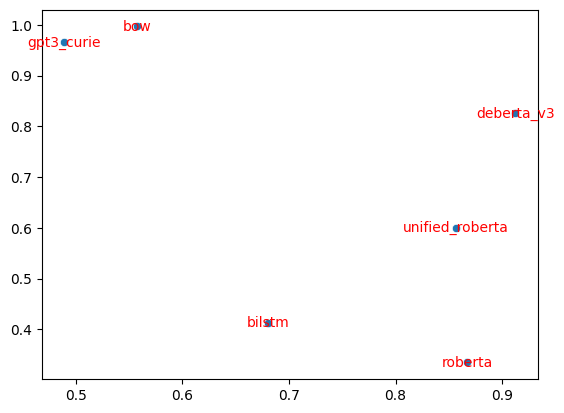

In [4]:
from simple_colors import *
import matplotlib.pyplot as plt
x = []
y = []
names = []

for model, results in human_results.items():
    analysis = results['snli-human']
    test_results = results['snli-test']
    
    print(green(model))
    variance_law = analysis.law_of_total_variance_breakdown()
    test_set_accuracy = test_results.accuracy
    print('Total variance:', variance_law['total_var_y'])
    print('Test set accuracy:', test_set_accuracy)
    print('Paraphrase acc:', analysis.paraphrase_accuracy())
    print('Variance of bernoulli with acc:', (analysis.paraphrase_accuracy() * (1-analysis.paraphrase_accuracy())))

    print("\n#### Agreement Consistency ####")
    
    print('Unweighted consistency:', analysis.mean_unweighted_consistency)
    print('Weighted consistency:', analysis.calculate_weighted_consistency(test_results))

    print("\n#### Linguistic Variance ####")
    print('Linguistic Variance:', variance_law['prop_explained'])
    print('Weighted Linguistic Variance:', analysis.calculate_weighted_proportion_explained(test_results))
    
    
    print()
    x.append(test_set_accuracy)
    y.append(analysis.calculate_weighted_proportion_explained(test_results))
    names.append(model)

sns.scatterplot(x=x, y=y)
for i in range(len(names)):
    plt.text(x[i], y[i], names[i], fontsize=10, ha='center', va='center', color='red')


In [ ]:
import plotly.express as px

# This plot shows that the there is positive correlation between how extreme the confidence is and discrete consistency.

model = human_results['roberta']['snli-human']

x = [b.original_example_prediction.confidence_deviation for b in model.buckets]
y = [b.bucket_discrete_agreement for b in model.buckets]

fig = px.scatter(x=x, y=y, labels={'x': 'deviation', 'y': 'discrete_agreement'}, trendline="ols")

fig.show()

### Do we need to calculate weighted proportion of explained or not?

In [ ]:
## just do a bunch of different resampling (10K), and then in expectation, 
## the prop explained should be the same as doing the reweighting
# is reweighting = upsampling?

hist, bin_edges = np.histogram(human_results['roberta']['snli-test'].confidences, bins=10, density=False, range=[0, 1])

weights = hist / np.sum(hist)
print(list(weights))

bin_ranges = [(bin_edges[i], bin_edges[i + 1]) for i in range(len(bin_edges) - 1)]
bins = {br: [] for br in bin_ranges}

for bucket in human_results['roberta']['snli-human'].buckets:
    placed = False
    for bin_range in bin_ranges:
        if bin_range[0] <= bucket.original_example_prediction.confidence_in_gold_label < bin_range[1]:
            bins[bin_range].append(bucket)
            placed = True
            break
    assert placed

selected_buckets = []

seed = [42, 1552, 124]
for s in seed:
    random.seed(s)

    for i in range(10000):
        # choose a bin
        sampled_bin = random.choices(bin_ranges, weights=weights, k=1)[0]
        selected_buckets.append(random.choice(bins[sampled_bin]))
    
    print(BucketDatasetResult(selected_buckets).law_of_total_variance_breakdown())

In [ ]:
human_results['roberta']['snli-human'].calculate_weighted_proportion_explained(
    human_results['roberta']['snli-test']
)